In [ ]:
!pip install segmentation-models-pytorch


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 100.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=50c36c80ee7d199c6ea4972bf850936d1d68b3abb5b3dcc7777d31b7ff263ecc
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=4d81631258506cd4debbd417bf49

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
from PIL import UnidentifiedImageError
import cv2
import segmentation_models_pytorch as sm


In [ ]:
!unzip /content/drive/MyDrive/siriraj-eye-dataset/Cup/cup_disc_segments.zip

In [ ]:
!unzip /content/drive/MyDrive/siriraj-eye-dataset/Image/all_images-001.zip

เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
  inflating: all_images/1750.jpg     
  inflating: all_images/1751.jpg     
  inflating: all_images/1752.jpg     
  inflating: all_images/1753.jpg     
  inflating: all_images/1754.jpg     
  inflating: all_images/1755.jpg     
  inflating: all_images/1756.jpg     
  inflating: all_images/1757.jpg     
  inflating: all_images/1758.jpg     
  inflating: all_images/1759.jpg     
  inflating: all_images/175L (C).jpg  
  inflating: all_images/175R (C).jpg  
  inflating: all_images/176.jpg      
  inflating: all_images/1760.jpg     
  inflating: all_images/1761.jpg     
  inflating: all_images/1762.jpg     
  inflating: all_images/1763.jpg     
  inflating: all_images/1764.jpg     
  inflating: all_images/1765.jpg     
  inflating: all_images/1766.jpg     
  inflating: all_images/1767.jpg     
  inflating: all_images/1768.jpg     
  inflating: all_images/1769.jpg     
  inflating: all_images/176L (C).jpg  
  inflating: all_images/176R

In [ ]:
def create_mask_from_txt(txt_path, img_size, padding=10):
    with open(txt_path, 'r') as f:
        coords = list(map(float, f.read().split()))[1:]
    coords = np.array(coords).reshape(-1, 2)
    coords[:, 0] *= img_size[1]
    coords[:, 1] *= img_size[0]

    coords[:, 0] = np.clip(coords[:, 0] + padding, 0, img_size[1] - 1)
    coords[:, 1] = np.clip(coords[:, 1] + padding, 0, img_size[0] - 1)

    mask = np.zeros(img_size, dtype=np.uint8)

    cv2.fillPoly(mask, [coords.astype(int)], color=1)

    return mask


In [ ]:
mask_dir = '/content/cup_labels'
txt_files = os.listdir(mask_dir)
mask_save_dir = '/content/cup_mask'
os.makedirs(mask_save_dir, exist_ok=True)

for txt_file in txt_files:
    txt_path = os.path.join(mask_dir, txt_file)
    mask = create_mask_from_txt(txt_path, img_size=(512, 512))
    mask_path = os.path.join(mask_save_dir, txt_file.replace('.txt', '.png'))
    cv2.imwrite(mask_path, mask * 255)

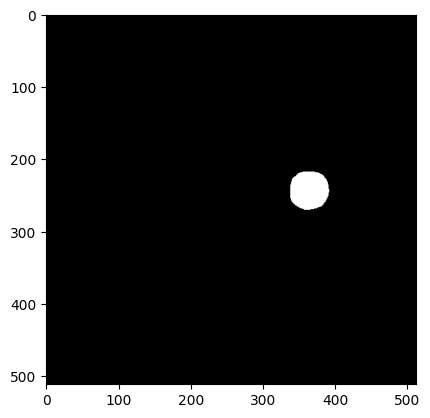

In [ ]:
mask_path = '/content/cup_mask/016R (2).png'
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(mask, cmap='gray')
plt.show()

In [ ]:
csv_file_path = '/content/drive/MyDrive/siriraj-eye-dataset/all_labels_processed.csv'
df = pd.read_csv(csv_file_path)

df = df.drop(columns=['camera','glaucoma_suspect','image_quality','image_quality_split', 'has_cup', 'has_disc', 'filename', 'has_disc_split','dr_label','dr_label_split'])

old_base_path = '../dataset/siriraj-eye-dataset-2023-jan/all_images'
new_base_path = '/content/all_images'
df['path'] = df['path'].apply(lambda x: x.replace(old_base_path, new_base_path).replace('\\', '/'))

In [ ]:
df.set_index('path', inplace=False)

,has_cup_split
path,
/content/all_images/0.jpg,NaN
/content/all_images/1.jpg,train
/content/all_images/2.jpg,train
/content/all_images/3.jpg,train
/content/all_images/4.jpg,train
...,...
/content/all_images/515L (C).jpg,NaN
/content/all_images/596L (c).jpg,train
/content/all_images/544L (C).jpg,train


In [ ]:
df = df.dropna(subset=['has_cup_split'])

In [ ]:
print(df)

                                  path has_cup_split
1            /content/all_images/1.jpg         train
2            /content/all_images/2.jpg         train
3            /content/all_images/3.jpg         train
4            /content/all_images/4.jpg         train
5            /content/all_images/5.jpg         train
...                                ...           ...
6161  /content/all_images/497R (C).jpg          test
6162  /content/all_images/293R (C).jpg         train
6164  /content/all_images/596L (c).jpg         train
6165  /content/all_images/544L (C).jpg         train
6166  /content/all_images/538L (C).jpg         train

[3256 rows x 2 columns]


In [ ]:
train_df = df[df['has_cup_split'] == 'train']
test_df = df[df['has_cup_split'] == 'test']
train_df, val_df = train_test_split(train_df, test_size=652/len(train_df), random_state=42)
train_df.drop(columns=['has_cup_split'], inplace=True)
val_df.drop(columns=['has_cup_split'], inplace=True)
test_df.drop(columns=['has_cup_split'], inplace=True)

<ipython-input-13-ab19fb493c07>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(columns=['has_cup_split'], inplace=True)


In [ ]:
print(val_df)

                                  path
3342      /content/all_images/3342.jpg
3347      /content/all_images/3347.jpg
3063      /content/all_images/3063.jpg
593        /content/all_images/593.jpg
5535  /content/all_images/342L (C).jpg
...                                ...
4411      /content/all_images/4411.jpg
4371      /content/all_images/4371.jpg
6109  /content/all_images/550R (C).jpg
3370      /content/all_images/3370.jpg
169        /content/all_images/169.jpg

[652 rows x 1 columns]


In [ ]:
from torch.utils.data import Dataset
from PIL import Image

class EyeDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


In [ ]:

train_images = train_df['path'].tolist()
train_masks = [path.replace('all_images', 'cup_mask').replace('.jpg', '.png') for path in train_images]

val_images = val_df['path'].tolist()
val_masks = [path.replace('all_images', 'cup_mask').replace('.jpg', '.png') for path in val_images]

test_images = test_df['path'].tolist()
test_masks = [path.replace('all_images', 'cup_mask').replace('.jpg', '.png') for path in test_images]



In [ ]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

train_dataset = EyeDataset(train_images, train_masks, transform=transform)
val_dataset = EyeDataset(val_images, val_masks, transform=transform)
test_dataset = EyeDataset(test_images, test_masks, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [ ]:
model = sm.Unet('resnet34', classes=2, activation=None)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 226MB/s]


In [ ]:
def iou_score(output, target):
    output = torch.argmax(output, dim=1)
    output_ = output > 0.5
    target_ = target > 0.5
    intersection = (output_ & target_).sum()
    union = (output_ | target_).sum()
    iou = intersection / union
    return iou.item()

def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_iou = 0.0

    for images, masks in loader:
        images = images.to(device)
        masks = masks.to(device).long()
        masks = masks.squeeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        running_iou += iou_score(outputs, masks)

    epoch_loss = running_loss / len(loader.dataset)
    epoch_iou = running_iou / len(loader.dataset)

    return epoch_loss, epoch_iou


def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_iou = 0.0

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device).long()
            masks = masks.squeeze(1)

            outputs = model(images)
            loss = criterion(outputs, masks)

            running_loss += loss.item() * images.size(0)
            running_iou += iou_score(outputs, masks)

    epoch_loss = running_loss / len(loader.dataset)
    epoch_iou = running_iou / len(loader.dataset)

    return epoch_loss, epoch_iou


In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (512, 512)
EPOCHS = 20

In [ ]:
best_loss = 10
best_model_path = '/content/drive/MyDrive/siriraj-eye-dataset/cup_model.pth'
patience = 5
patience_counter = 0

train_losses = []
train_ious = []
val_losses = []
val_ious = []

for epoch in range(EPOCHS):
    train_loss, train_iou = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_iou = validate(model, val_loader, criterion, device)
    print(f'Epoch [{epoch+1}/{EPOCHS}], '
          f'Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}')

    train_losses.append(train_loss)
    train_ious.append(train_iou)
    val_losses.append(val_loss)
    val_ious.append(val_iou)

    if val_loss < best_loss:
        print(f'New best model found! Previous best loss: {best_loss:.4f}, new best loss: {val_loss:.4f}. Saving model...')
        torch.save(model.state_dict(), best_model_path)
        best_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        print(f'Patience counter: {patience_counter}')
        if patience_counter >= patience:
            print('Early stopping triggered.')
            break

Epoch [1/20], Train Loss: 0.0190, Train IoU: 0.0657, Val Loss: 0.0041, Val IoU: 0.0831
New best model found! Previous best loss: 10.0000, new best loss: 0.0041. Saving model...
Epoch [2/20], Train Loss: 0.0040, Train IoU: 0.0816, Val Loss: 0.0034, Val IoU: 0.0852
New best model found! Previous best loss: 0.0041, new best loss: 0.0034. Saving model...
Epoch [3/20], Train Loss: 0.0032, Train IoU: 0.0858, Val Loss: 0.0035, Val IoU: 0.0769
Patience counter: 1
Epoch [4/20], Train Loss: 0.0029, Train IoU: 0.0888, Val Loss: 0.0027, Val IoU: 0.0912
New best model found! Previous best loss: 0.0034, new best loss: 0.0027. Saving model...
Epoch [5/20], Train Loss: 0.0027, Train IoU: 0.0907, Val Loss: 0.0026, Val IoU: 0.0890
New best model found! Previous best loss: 0.0027, new best loss: 0.0026. Saving model...
Epoch [6/20], Train Loss: 0.0026, Train IoU: 0.0914, Val Loss: 0.0026, Val IoU: 0.0921
New best model found! Previous best loss: 0.0026, new best loss: 0.0026. Saving model...
Epoch [7/20]

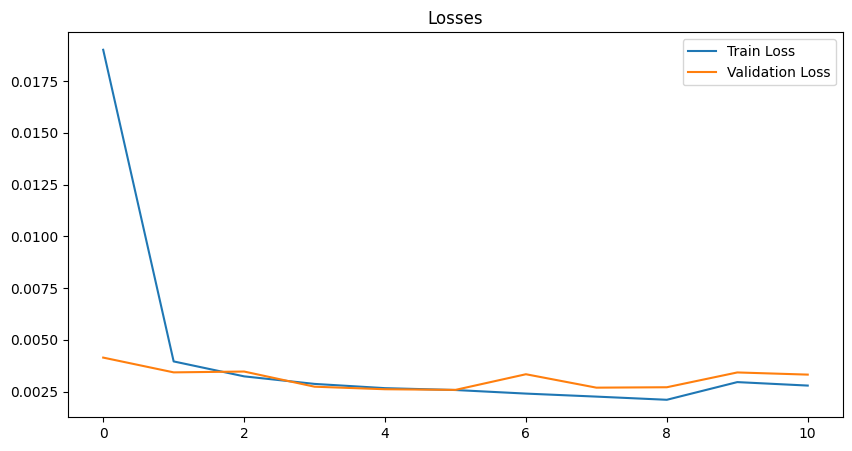

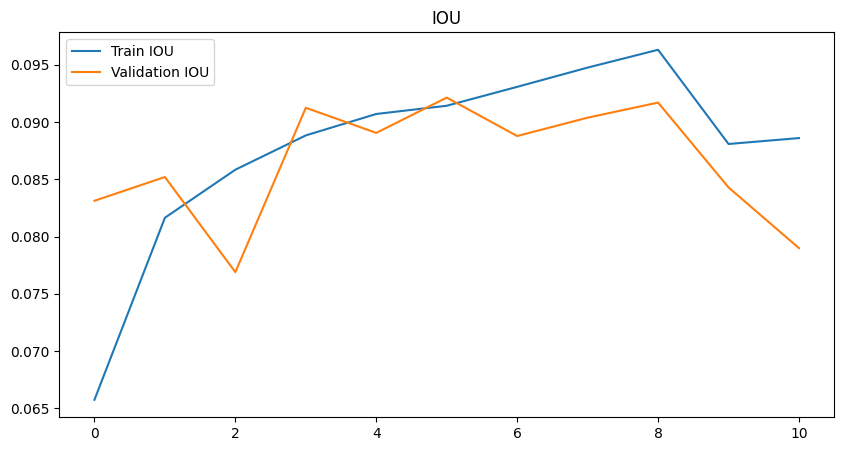

In [ ]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Losses')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_ious, label='Train IOU')
plt.plot(val_ious, label='Validation IOU')
plt.title('IOU')
plt.legend()
plt.show()

Test Loss: 0.0033, Test IoU: 0.0803


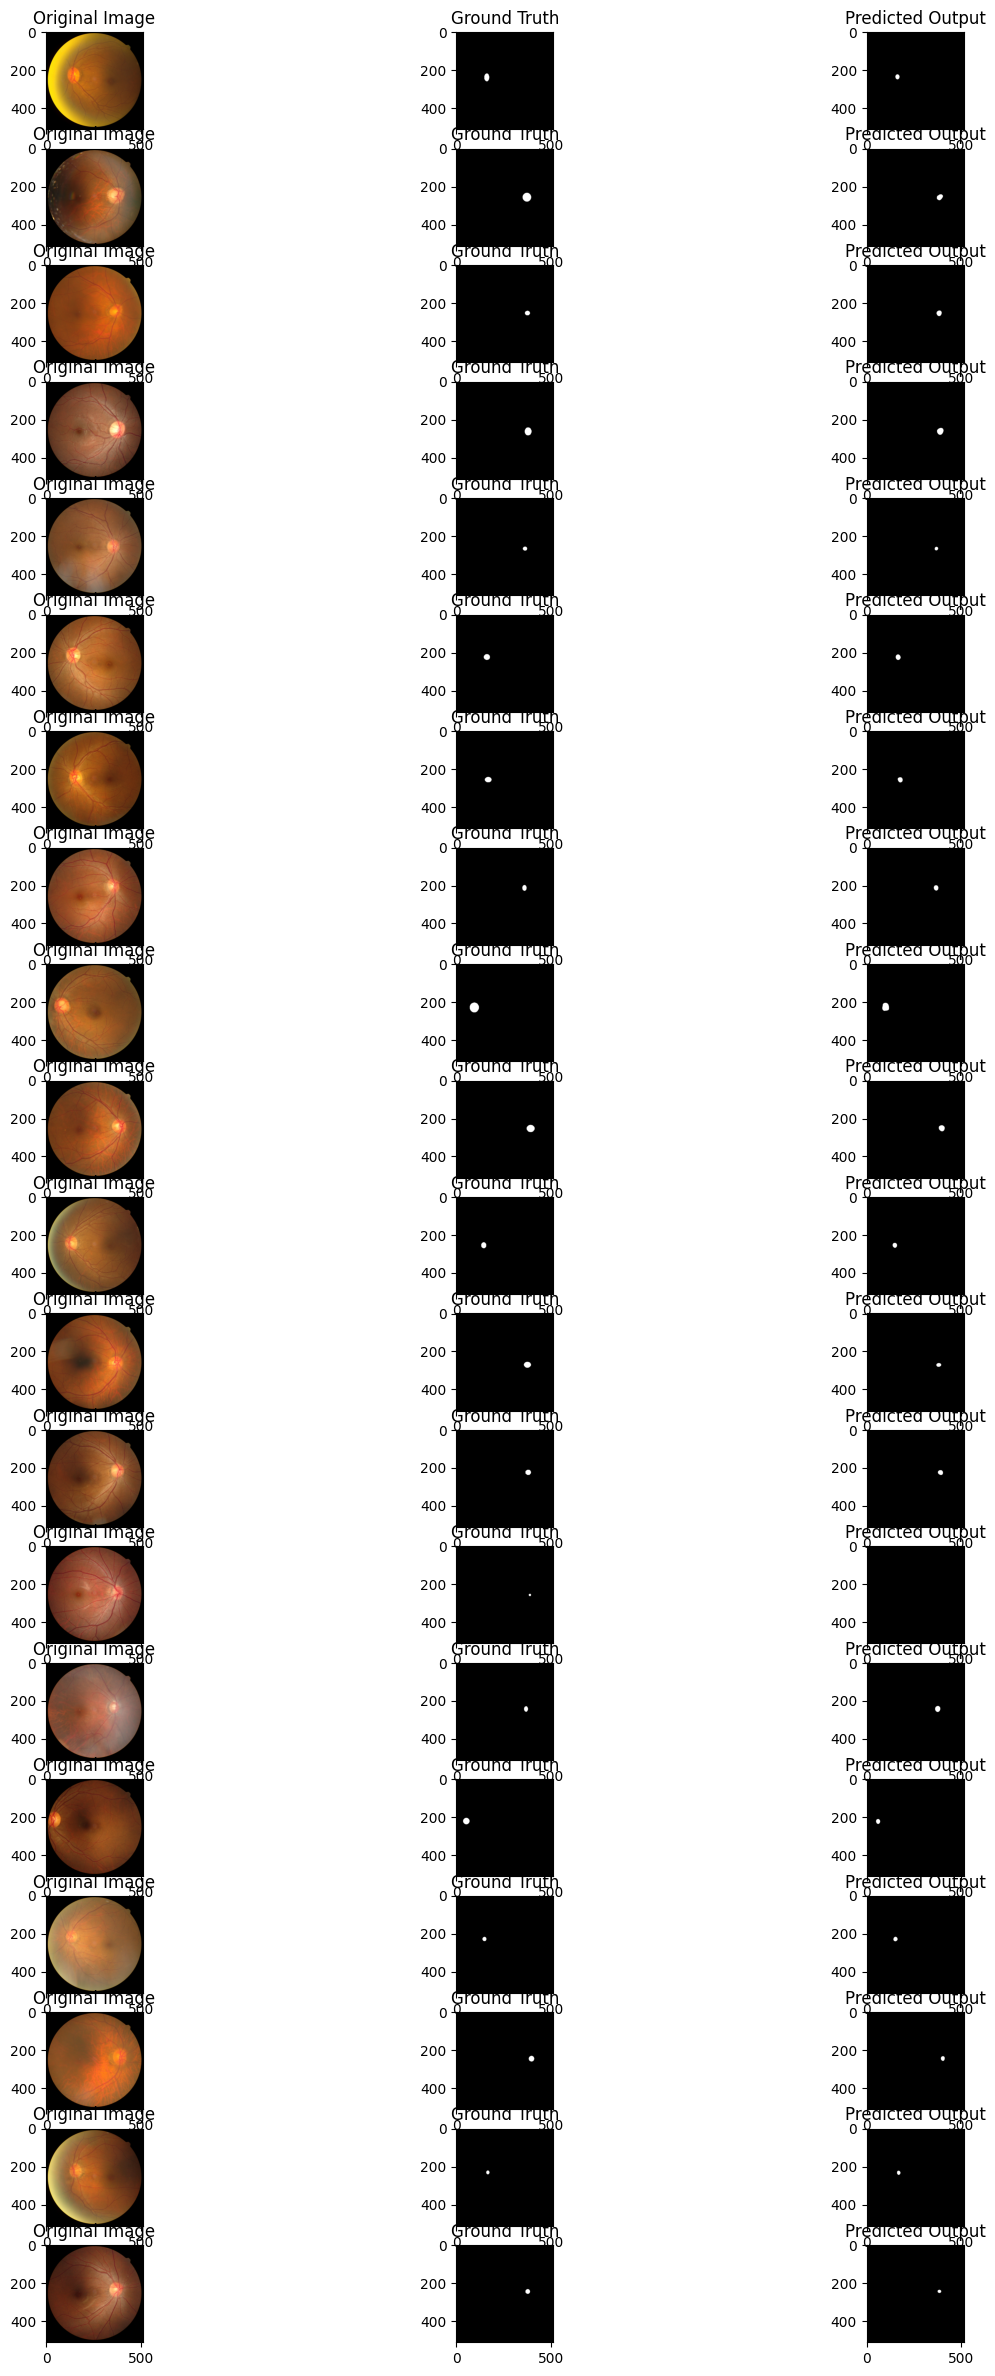

In [ ]:
model.eval()
test_loss, test_iou = validate(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test IoU: {test_iou:.4f}')

# Visualize the results
fig = plt.figure(figsize=(15, 30))
num_images = 0

with torch.no_grad():
    for i, (images, masks) in enumerate(test_loader):
        if num_images == 60:
            break

        images = images.to(device)
        masks = masks.to(device).long()
        masks = masks.squeeze(1)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        for j in range(images.size(0)):
            if num_images == 60:
                break

            num_images += 1
            ax = fig.add_subplot(20, 3, num_images)
            ax.imshow(images.cpu().data[j].numpy().transpose((1, 2, 0)), cmap='gray')
            ax.title.set_text('Original Image')

            num_images += 1
            ax = fig.add_subplot(20, 3, num_images)
            ax.imshow(masks.cpu().data[j].numpy().squeeze(), cmap='gray')
            ax.title.set_text('Ground Truth')

            num_images += 1
            ax = fig.add_subplot(20, 3, num_images)
            ax.imshow(preds.cpu().data[j].numpy().squeeze(), cmap='gray')
            ax.title.set_text('Predicted Output')

plt.show()